# EXPLORATION_9. 폐렴아 기다려라!

## 목차

1. 실습환경 set-up
2. 데이터 준비하기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화

### 실습환경 set-up

In [3]:
# 사용할 라이브러리 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
# 앞으로 필요한 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### 데이터 준비하기

In [5]:
# 준비된 train / val / test 데이터 확인

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train데이터 수:', len(train_filenames))
print('test데이터 수:', len(test_filenames))
print('val데이터 수:', len(val_filenames))

train데이터 수: 5216
test데이터 수: 624
val데이터 수: 16


In [6]:
# val 데이터의 수가 너무 적기때문에 train 데이터에서 val 데이터로 데이터를 옮겨준다.

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('변경된 train 데이터:', len(train_filenames))
print('변경된 val 데이터:', len(val_filenames))

변경된 train 데이터: 4185
변경된 val 데이터: 1047


In [7]:
# 정상 이미지와 폐렴 이미지 개수 확인

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


  - 정상 이미지는 파일 이름에 normal / 폐렴 이미지는 파일 이름에 pneumonia로 되어있다.
  - 이것을 이용하면 정상 이미지와 페렴 이미지를 구분할 수 있다.
  - 또 결과를 보면 폐렴 이미지의 수가 정상 이미지보다 약 3배정도 많다.
  - CNN 모델은 데이터가 클래스별 balance가 좋을수록 training을 잘한다.
  - 그렇기때문에 데이터 불균형(imbalance)한 것을 조정해주어야 한다.

In [9]:
# td.data 인스턴스 만들기

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
# train / val 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 라벨 데이터 만들어주기

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

print('good')

good


In [13]:
# train dataset / val dataset 만들기

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
# 이미지 및 라벨 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
# test dataset 만들기

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

  - 준비한 데이터를 시각화해서 보기 쉽게 표현할 수 있다.

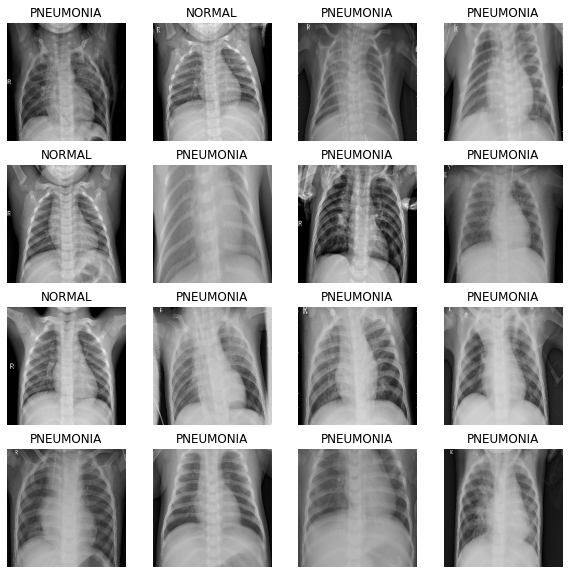

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링

  - 여기서 CNN 모델을 사용하는 이유는 CNN 모델이 이미지 처리에 특화된 딥러닝 모델이기 때문이다.

In [15]:
# Convolution block 만들기

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
# Dense block 만들기

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리

  - 데이터중에 normal과 pneumonia의 차이는 약 3배의 차이였다.
  - 한 라벨이 너무 많은 경우를 imbalance하다고 하는데 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.
  - 이런 문제를 해결하기 위해서 Weight balancing 이라는 테크닉을 사용한다.
  - Weight balancing은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss값을 가지도록 가중치를 부여하는 방법이다.

In [18]:
# weight_for_0은 Normal / weight_for_1은 Pneumonia에 사용

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 모델 훈련

  - 이미지 훈련은 GPU를 사용하기 때문에 먼저 GPU를 선택해줘야 한다.
  - 위에서 만든 모델 함수인 build_model( )에 model을 선언해서 사용한다.
  - 이미지의 라벨이 두개밖에 없기 때문에 binary_cross entropy 손실함수를 사용한다.
  - optimizer는 adam을 사용한다.
  - 성과측정을 위한 metrics로는 accuracy, precision, recall을 사용한다.

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# BATCH_SIZE = 16, / epochs = 25로 훈련 진행

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 187ms/step - loss: 0.4137 - accuracy: 0.8024 - precision: 0.9458 - recall: 0.7794 - val_loss: 0.7206 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 186ms/step - loss: 0.2388 - accuracy: 0.9112 - precision: 0.9779 - recall: 0.9006 - val_loss: 1.4464 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1904 - accuracy: 0.9310 - precision: 0.9786 - recall: 0.9276 - val_loss: 0.1825 - val_accuracy: 0.9125 - val_precision: 0.8946 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1826 - accuracy: 0.9318 - precision: 0.9793 - recall: 0.9279 - val_loss: 0.3632 - val_accuracy: 0.8404 - val_precision: 0.8222 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 50s 194ms/step - loss: 0.1572 - accura

### 결과 확인 및 시각화

  - 시각화를 통해서 epochs마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 알 수 있다.

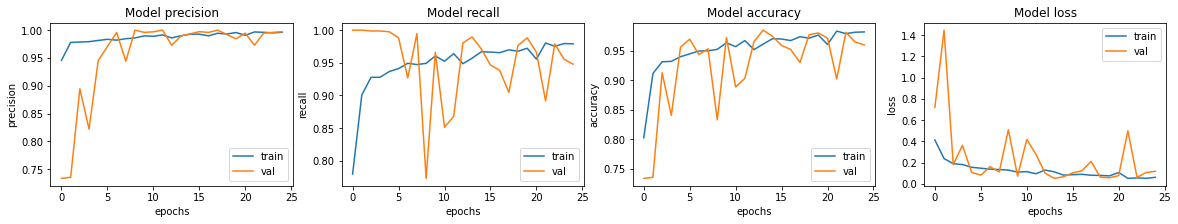

In [22]:
# 모델 훈련 결과 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 테스트 데이터를 사용한 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.9045 - accuracy: 0.8253 - precision: 0.7958 - recall: 0.9692
Loss: 0.9044877290725708,
Accuracy: 0.8253205418586731,
Precision: 0.7957894802093506,
Recall: 0.9692307710647583


### 모델 개선 1 - augmentation 도입

  - 모델의 accuracy를 85%까지 향상시키기 위해서 시도해볼 첫번째 시도는 augmentation 도입이다.
  - 의료 영상의 경우 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다.
  - 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문이다.
  - 여기서는 좌우 반전 정도의 augmentation만 도입해서 진행해본다.

In [24]:
# train / val dataset 추가로 만들기

train_ds_1 = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_1 = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_1 = prepare_for_training(train_ds_1)
val_ds_1 = prepare_for_training(val_ds_1)

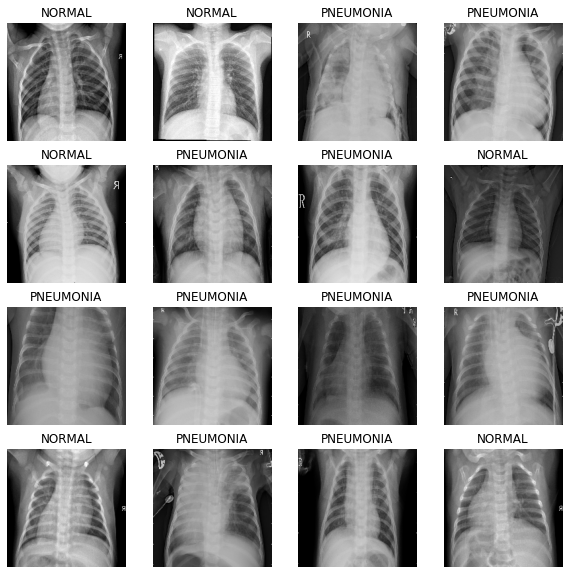

In [26]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_1))
show_batch(image_batch.numpy(), label_batch.numpy())

In [27]:
# BATCH_SIZE = 16, / epochs = 25로 훈련 진행

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 57s 190ms/step - loss: 0.2071 - accuracy: 0.9131 - precision: 0.9797 - recall: 0.9017 - val_loss: 0.0850 - val_accuracy: 0.9654 - val_precision: 0.9828 - val_recall: 0.9699
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1443 - accuracy: 0.9447 - precision: 0.9835 - recall: 0.9414 - val_loss: 0.0751 - val_accuracy: 0.9760 - val_precision: 0.9768 - val_recall: 0.9908
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1331 - accuracy: 0.9507 - precision: 0.9879 - recall: 0.9454 - val_loss: 0.0709 - val_accuracy: 0.9740 - val_precision: 0.9933 - val_recall: 0.9712
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1223 - accuracy: 0.9557 - precision: 0.9854 - recall: 0.9545 - val_loss: 0.1737 - val_accuracy: 0.9288 - val_precision: 1.0000 - val_recall: 0.9034
Epoch 5/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1006 - accura

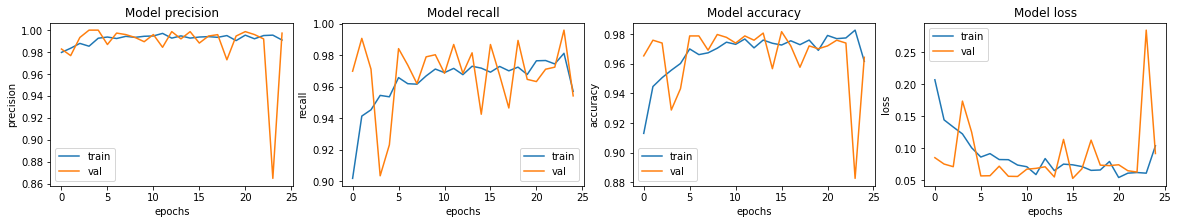

In [28]:
# 모델 훈련 결과 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
# 테스트 데이터를 사용한 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 1.4161 - accuracy: 0.7885 - precision: 0.7590 - recall: 0.9692
Loss: 1.416092872619629,
Accuracy: 0.7884615659713745,
Precision: 0.759036123752594,
Recall: 0.9692307710647583


  - augmentation을 도입해서 모델을 훈련시키고 테스트했을때 오히려 초기 모델보다 더 낮은 accuracy를 얻었다.
  - 정확도 상승을 위해서 model에서 변경 가능한 수치들을 조절해서 테스트를 해야 할 것 같다.

### 모델 개선 2 - batch_size 조절 16 -> 32

In [31]:
BATCH_SIZE = 32
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 35s 216ms/step - loss: 0.0813 - accuracy: 0.9750 - precision: 0.9953 - recall: 0.9707 - val_loss: 0.0630 - val_accuracy: 0.9727 - val_precision: 0.9973 - val_recall: 0.9660
Epoch 2/25
130/130 [==============================] - 28s 213ms/step - loss: 0.0503 - accuracy: 0.9827 - precision: 0.9974 - recall: 0.9794 - val_loss: 0.0525 - val_accuracy: 0.9844 - val_precision: 0.9947 - val_recall: 0.9842
Epoch 3/25
130/130 [==============================] - 28s 213ms/step - loss: 0.0636 - accuracy: 0.9817 - precision: 0.9947 - recall: 0.9806 - val_loss: 0.1188 - val_accuracy: 0.9590 - val_precision: 1.0000 - val_recall: 0.9441
Epoch 4/25
130/130 [==============================] - 28s 218ms/step - loss: 0.0454 - accuracy: 0.9822 - precision: 0.9941 - recall: 0.9819 - val_loss: 0.0695 - val_accuracy: 0.9727 - val_precision: 0.9972 - val_recall: 0.9651
Epoch 5/25
130/130 [==============================] - 29s 222ms/step - loss: 0.0439 - accura

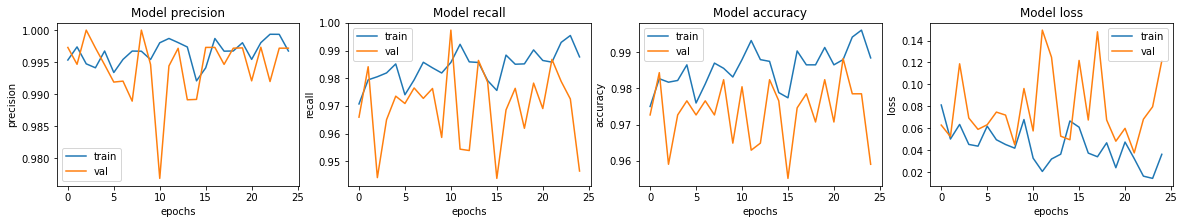

In [32]:
# 모델 훈련 결과 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
# 테스트 데이터를 사용한 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 0.9746 - accuracy: 0.8269 - precision: 0.7925 - recall: 0.9795
Loss: 0.9745568633079529,
Accuracy: 0.8269230723381042,
Precision: 0.7925311326980591,
Recall: 0.9794871807098389


  - batch_size를 16에서 32로 높여서 테스트를 진행한결과 약 83%의 정확도를 얻었다.
  - 처음 노드를 따라 진행한 모델과 비슷한 정확도였다.
  - 의료 케이스에서 중요한 지표인 recall은 0.96에서 0.97로 조금 상승하였다.

### 모델 개선 3 - batch_size 32 -> 64 변경

In [20]:
BATCH_SIZE = 64
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
65/65 [==============================] - 56s 290ms/step - loss: 0.5634 - accuracy: 0.7279 - precision: 0.9284 - recall: 0.6873 - val_loss: 0.5971 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 2/25
65/65 [==============================] - 18s 284ms/step - loss: 0.4100 - accuracy: 0.8452 - precision: 0.9603 - recall: 0.8233 - val_loss: 0.5475 - val_accuracy: 0.7695 - val_precision: 0.7695 - val_recall: 1.0000
Epoch 3/25
65/65 [==============================] - 19s 292ms/step - loss: 0.3394 - accuracy: 0.8471 - precision: 0.9637 - recall: 0.8254 - val_loss: 0.6132 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 4/25
65/65 [==============================] - 20s 308ms/step - loss: 0.3150 - accuracy: 0.8769 - precision: 0.9647 - recall: 0.8691 - val_loss: 0.6854 - val_accuracy: 0.7188 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 21s 319ms/step - loss: 0.2763 - accuracy: 0.8894

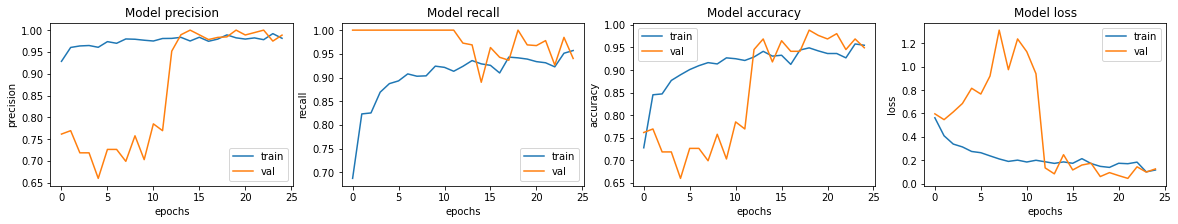

In [21]:
# 모델 훈련 결과 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
# 테스트 데이터를 사용한 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.4138 - accuracy: 0.8510 - precision: 0.8249 - recall: 0.9667
Loss: 0.41383764147758484,
Accuracy: 0.8509615659713745,
Precision: 0.8249452710151672,
Recall: 0.9666666388511658


  - batch_size를 32에서 64로 한번 더 높여서 모델을 평가하니까 원하는 결과인 accuracy 85%가 나왔다.
  - 사실 epochs도 15로 내려서도 테스트해봤지만 결과는 76%로 저조한 결과를 얻었다.

### 모델 개선 4 - CNN 모델 수정해보기

In [23]:
# Convolution block 만들기

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [24]:
# Dense block 만들기
# 우리가 수정할 부분은 BatchNormalizaion과 Dropout을 제거한 Dense_block를 사용한다.

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
    ])
    
    return block

In [25]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [26]:
# 다시 BATCH_SIZE = 16, / epochs = 25로 원상 복구 한 후 훈련 진행
BATCH_SIZE = 16
EPOCHS = 25

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 190ms/step - loss: 0.1390 - accuracy: 0.9461 - precision: 0.9845 - recall: 0.9424 - val_loss: 0.0960 - val_accuracy: 0.9615 - val_precision: 0.9549 - val_recall: 0.9948
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1321 - accuracy: 0.9521 - precision: 0.9856 - recall: 0.9494 - val_loss: 0.0726 - val_accuracy: 0.9731 - val_precision: 0.9894 - val_recall: 0.9739
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1401 - accuracy: 0.9473 - precision: 0.9869 - recall: 0.9418 - val_loss: 0.1383 - val_accuracy: 0.9500 - val_precision: 0.9917 - val_recall: 0.9398
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1182 - accuracy: 0.9535 - precision: 0.9863 - recall: 0.9508 - val_loss: 0.1675 - val_accuracy: 0.9385 - val_precision: 1.0000 - val_recall: 0.9162
Epoch 5/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1151 - accura

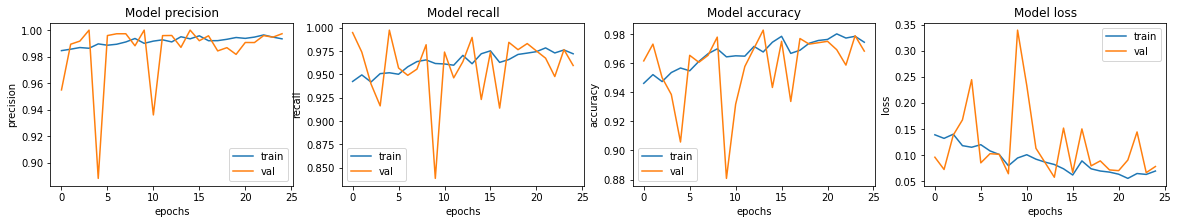

In [27]:
# 모델 훈련 결과 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
# 테스트 데이터를 사용한 모델 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.5842 - accuracy: 0.8558 - precision: 0.8219 - recall: 0.9821
Loss: 0.5842376947402954,
Accuracy: 0.8557692170143127,
Precision: 0.8218883872032166,
Recall: 0.9820512533187866


  - BatchNormalizaion과 Dropout을 제거한 모델에서도 accuracy 85%의 결과를 얻었다.
  - recall값 역시 여태까지의 모델들 중 가장 높은 수치인 0.98을 기록하였다.

## 회고

  - 분류 관련 노드는 내가 직접 모델을 이것 저것 조절해서 accuracy를 얻기 때문에 생각보다 재미있던 것 같다.
  - 하지만 아직도 데이터를 준비하는 전처리 과정과 모델의 성능을 향상 시키기 위한 하이퍼 파라미터 수정에 있어서 최적의 결과를 얻는게 어려운 것 같다.
  - 지금은 최적의 값이 아닌 내가 생각하는 최적의 값을 임의로 설정해서 모델을 돌렸고 그래서 얻은 결과가 사실 데이터에 의거해서 얻은 결과인지에 대한 확신이 크게 없다.
  - 내가 준비한 데이터를 모델에 넣어서 임의로 넣은 설정값이 아닌 최적의 값을 넣어서 최고의 결과를 얻기 위해서는 데이터를 더 깔끔하게 만들고 최적의 하이퍼 파라미터 값을 구하는 법을 좀 더 공부해야 할 것 같다.
  - 여기서는 이미지 분류에 강점이 있는 CNN 모델을 사용해서 프로젝트를 진행했는데 CNN 모델 이외에 다른 분류 모델을 사용해서도 결과를 얻어보면 좋을 것 같다.
  - 아직은 분류 혹은 회귀 등 어떤 분야에 있어서 어떤 모델을 사용하는게 좋은지 스스로 판단하기는 어려운데 다양한 분류, 회귀 등의 문제들을 보고 어떤 문제에 어떤 모델을 사용해야 하는지 익숙해지기 위해서 꾸준히 공부를 해야 할 것 같다.